In [1]:
# pip install git+https://github.com/IBM/terratorch.git ##used this code to get latest terratorch download

from Decoder_UNet2D import UNet2D
from Encoder_TerraMind import TerraMindEncoder
from DataLoader import BeforeData
# from Losses import DiceLoss
from monai.losses.dice import DiceLoss # replaced the above loss
from utils import RandomCrop
from utils import RandomFlipPair
from utils import RandomRotationPair



import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import np



INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


/var/folders/v6/pv2sv4yx3_q6j2_n2pr5wfkm0000gn/T/ipykernel_55116/309516774.py:24: RuntimeWarning: divide by zero encountered in divide
  weights = num_pixels.sum() / (3 * num_pixels)  # divide by 3 to normalize


Epoch 1/50 - Loss: 0.8263 - Accuracy: 0.6493
Epoch 2/50 - Loss: 0.3413 - Accuracy: 0.9132
Epoch 3/50 - Loss: 0.2658 - Accuracy: 0.9180
Epoch 4/50 - Loss: 0.2210 - Accuracy: 0.9325
Epoch 5/50 - Loss: 0.1982 - Accuracy: 0.9357
Epoch 6/50 - Loss: 0.1984 - Accuracy: 0.9352
Epoch 7/50 - Loss: 0.1855 - Accuracy: 0.9383
Epoch 8/50 - Loss: 0.1878 - Accuracy: 0.9380
Epoch 9/50 - Loss: 0.1742 - Accuracy: 0.9413
Epoch 10/50 - Loss: 0.1786 - Accuracy: 0.9405
Epoch 11/50 - Loss: 0.1870 - Accuracy: 0.9364
Epoch 12/50 - Loss: 0.1767 - Accuracy: 0.9393
Epoch 13/50 - Loss: 0.1741 - Accuracy: 0.9388
Epoch 14/50 - Loss: 0.1596 - Accuracy: 0.9456
Epoch 15/50 - Loss: 0.1713 - Accuracy: 0.9395
Epoch 16/50 - Loss: 0.1671 - Accuracy: 0.9418
Epoch 17/50 - Loss: 0.1404 - Accuracy: 0.9534
Epoch 18/50 - Loss: 0.1391 - Accuracy: 0.9548
Epoch 19/50 - Loss: 0.1446 - Accuracy: 0.9509
Epoch 20/50 - Loss: 0.1491 - Accuracy: 0.9494
Epoch 21/50 - Loss: 0.1351 - Accuracy: 0.9552
Epoch 22/50 - Loss: 0.1507 - Accuracy: 0.94

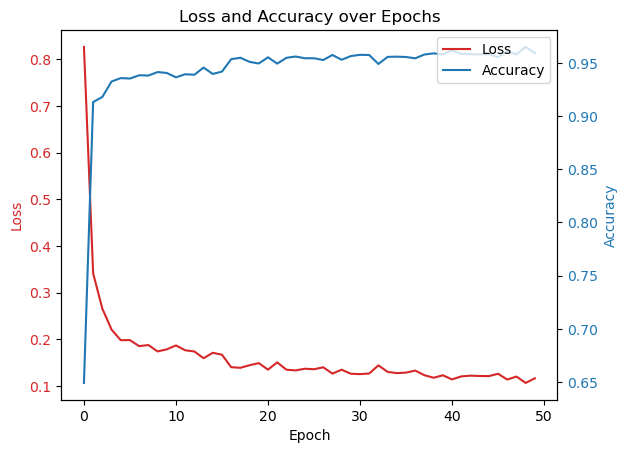

In [11]:
# -----params----- #
learning_rate = 0.0005
num_classes = 3
num_augmentations = 32
batch_size = 4
num_epochs = 50
# activation_function = "softmax" #["softmax", "sigmoid"]

# ------Loading in models + data + helper functions --------- #
dataset = BeforeData(before_dir = os.getcwd()+ "/Images/Before",
                     after_dir = os.getcwd()+ "/Images/After",
                     label_dir = os.getcwd() + "/Images/Relabeled",
                     split = 'train', 
                     num_augmentations= num_augmentations)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

num_pixels = np.zeros(3)  # classes 0,1,2
for _, y in dataloader:   # iterate through dataset
    y_np = y.numpy()
    for c in [1,2]:       # ignore 0
        num_pixels[c] += (y_np == c).sum()

# Inverse frequency weighting
weights = num_pixels.sum() / (3 * num_pixels)  # divide by 3 to normalize
weights[0] = 0  # ignore background
class_weights = torch.tensor(weights, dtype=torch.float32)

# criterion = DiceLoss(include_background = False)
criterion = nn.CrossEntropyLoss(ignore_index=0)

encoder = TerraMindEncoder()
decoder = UNet2D(num_classes=num_classes)
for param in encoder.parameters():
    param.requires_grad = False
optimizer = optim.Adam(#list(encoder.parameters()) + 
    list(decoder.parameters()),
     lr=learning_rate)


device = "cuda" if torch.cuda.is_available() else "cpu"
encoder.to(device)
decoder.to(device)


sigmoid = nn.Sigmoid() 
softmax = nn.Softmax(dim=1)
# ---- Training Loop ---- #
epochs = num_epochs
losses = []
accuracies = []
for epoch in range(epochs):
    encoder.eval()
    decoder.train()
    running_loss = 0.0
    total_correct = 0.0
    total_pixels = 0.0

    
    for (x_before, x_after), y in dataloader:
        x_before, x_after, y = x_before.to(device), x_after.to(device), y.to(device)

        z_before = encoder(x_before)
        z_after = encoder(x_after)
        z_differenced = [after - before for before, after in zip(z_before, z_after)]
        # z_differenced = [(a-b)/torch.std(a-b) for a,b in zip(z_after,z_before)]

        optimizer.zero_grad()
        logits = decoder(z_differenced)
        # print(logits.max(), logits.min(), logits.mean())
        # if activation_function == "sigmoid":
        #     activation = sigmoid(logits)
        # else:
        #     activation = softmax(logits)    
        # y_onehot = F.one_hot(y_onehot.long(), num_classes=num_classes).permute(0, 3, 1, 2).float() ###START HERE, FIGURING OUT -1 in classes


        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x_before.size(0) #batch size
        # print("loss:", loss)
        predictions = torch.argmax(logits, dim=1)
        # total_correct += torch.sum(predictions == y)
        # total_pixels += y.numel()
        
        mask = (y != 0)
        total_correct += (predictions[mask] == y[mask]).sum().item()
        total_pixels += mask.sum().item()
        
        

    epoch_loss = running_loss / len(dataset)
    losses.append(epoch_loss)
    accuracies.append(total_correct/total_pixels)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Accuracy: {total_correct/total_pixels:.4f}")
    

#plot Loss and Accuracy
fig, ax1 = plt.subplots()

# Plot losses on the left y-axis
ax1.plot(losses, color="tab:red", label="Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color="tab:red")
ax1.tick_params(axis="y", labelcolor="tab:red")

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
ax2.plot(accuracies, color="tab:blue", label="Accuracy")
ax2.set_ylabel("Accuracy", color="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:blue")

# Add legends
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.title("Loss and Accuracy over Epochs")
plt.show()

In [21]:
print(logits.shape)
print(F.softmax(logits[0,:,200,200]))

torch.Size([4, 3, 224, 224])
tensor([9.0994e-09, 9.8727e-01, 1.2725e-02], grad_fn=<SoftmaxBackward0>)


/var/folders/v6/pv2sv4yx3_q6j2_n2pr5wfkm0000gn/T/ipykernel_55116/3383425635.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(logits[0,:,200,200]))


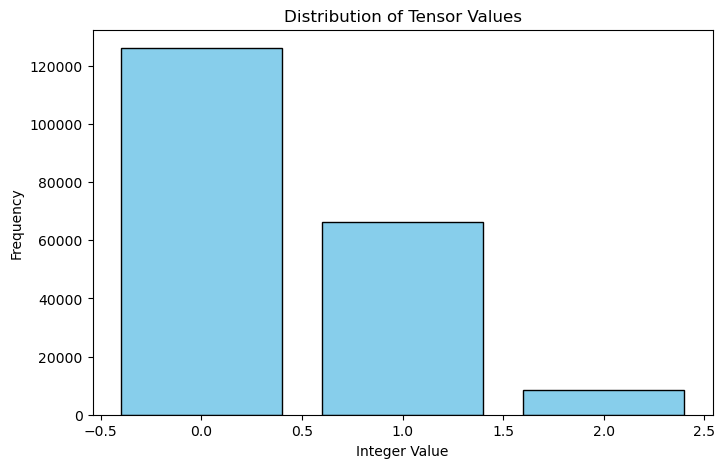

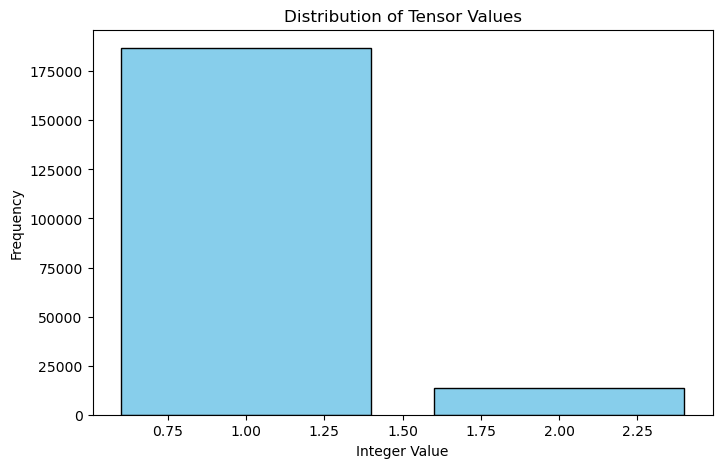

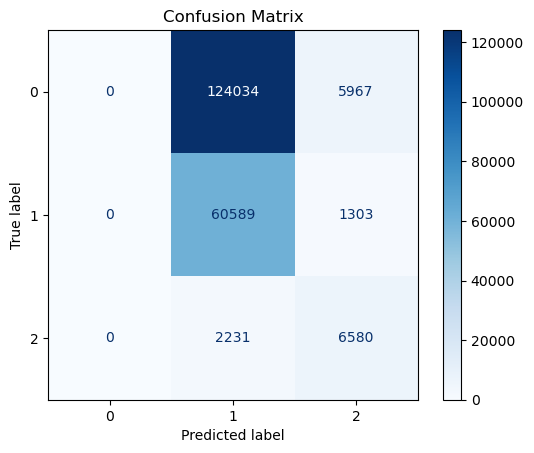

In [17]:
for i in dataloader:
    b, a, l = i[0][0], i [0][1], i[1]

l = l.flatten()
plt.figure(figsize=(8,5))
plt.hist(l, bins=range(l.min(),l.max()+2), align='left', rwidth=0.8, color="skyblue", edgecolor="black")
plt.xlabel("Integer Value")
plt.ylabel("Frequency")
plt.title("Distribution of Tensor Values")
plt.show()



p = predictions.flatten()
plt.figure(figsize=(8,5))
plt.hist(p, bins=range(p.min(),p.max()+2), align='left', rwidth=0.8, color="skyblue", edgecolor="black")
plt.xlabel("Integer Value")
plt.ylabel("Frequency")
plt.title("Distribution of Tensor Values")
plt.show()

cm = confusion_matrix(y.cpu().numpy().ravel(),predictions.cpu().numpy().ravel())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues) # You can choose different colormaps
plt.title('Confusion Matrix')
plt.show()



In [99]:

encoder = TerraMindEncoder()
decoder = UNet2D()

# # composed = transforms.Compose([RandomCrop(224)])
# composed = transforms.Compose([
#     RandomCrop(224),
#     # RandomFlipPair(),
#     # RandomRotationPair()
# ])

dataset = BeforeData(before_dir = os.getcwd()+ "/Images/Before",
                     after_dir = os.getcwd()+ "/Images/After",
                     label_dir = os.getcwd() + "/Images/Label",
                    #  input_size = 224
                     transform = composed
                     )
dataloader = DataLoader(dataset)#, batch_size=1, shuffle=True)#, num_workers=0)

criterion = DiceLoss()
sigmoid = nn.Sigmoid() # probably can and should delete this? Should be in Encoder


device = "cuda" if torch.cuda.is_available() else "cpu"
encoder.to(device)
decoder.to(device)

# ---- Test Loop ----

losses = []
accuracies = []
running_loss = 0.0


encoder.eval()
decoder.eval()
with torch.no_grad():  # no gradients for inference

    for (x_before, x_after), y in dataloader:
        # print("Y shape:", y.shape)
        x_before, x_after, y = x_before.to(device), x_after.to(device), y.to(device)

        # Forward pass (explicit encoder + decoder)
        z_before = encoder(x_before)
        z_after = encoder(x_after)
        z_differenced = [after - before for before, after in zip(z_before, z_after)]

        logits = decoder(z_differenced) # reconstruction
        print(logits.shape)

        predictions = sigmoid(logits) # should this be moved to encoder?
        y_onehot = F.one_hot(y.long(), num_classes=4).permute(0, 3, 1, 2).float()

        loss = criterion(predictions, y_onehot)
        losses.append(epoch_loss)
        running_loss += loss.item() * x_before.size(0)

        predictions = torch.argmax(logits, dim=1)         # shape: [N, H, W]
        accuracies.append(torch.sum(predictions == y)/y.numel())        
    

# plt.plot(losses, label = "Loss")
# plt.plot(accuracies, label = "Accuracy")
# plt.legend()
# plt.show()

cm = confusion_matrix(predictions.cpu().numpy().ravel(), y.cpu().numpy().ravel())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues) # You can choose different colormaps
plt.title('Confusion Matrix')
plt.show()

print("Accuracy:", accuracies)

NameError: name 'composed' is not defined